# Diabetes Prediction with the PIMA Indian Diabetes Dataset #
#### *This project explores the mathematical foundations of neural networks, focusing on understanding how mathematics can uncover complex relationships within diverse datasets*

In [12]:
import torch
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [107]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

The dataset for this project is sourced from the PIMA Indians Diabetes Dataset, sourced from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [29]:
# Observe the dataset for the data columns and any missing data values
display(df.head())
display(df.isna().sum())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Noting the data columns, there are 8 columns containing data relevant to the patient, and one column (Outcome) relating to the diabetes status of the patient. From the dataset, an outcome of 1 indicates that the patient has diabetes, and an outcome of 0 indicates that the patient does not have diabetes.

In [34]:
# Preprocess the dataset

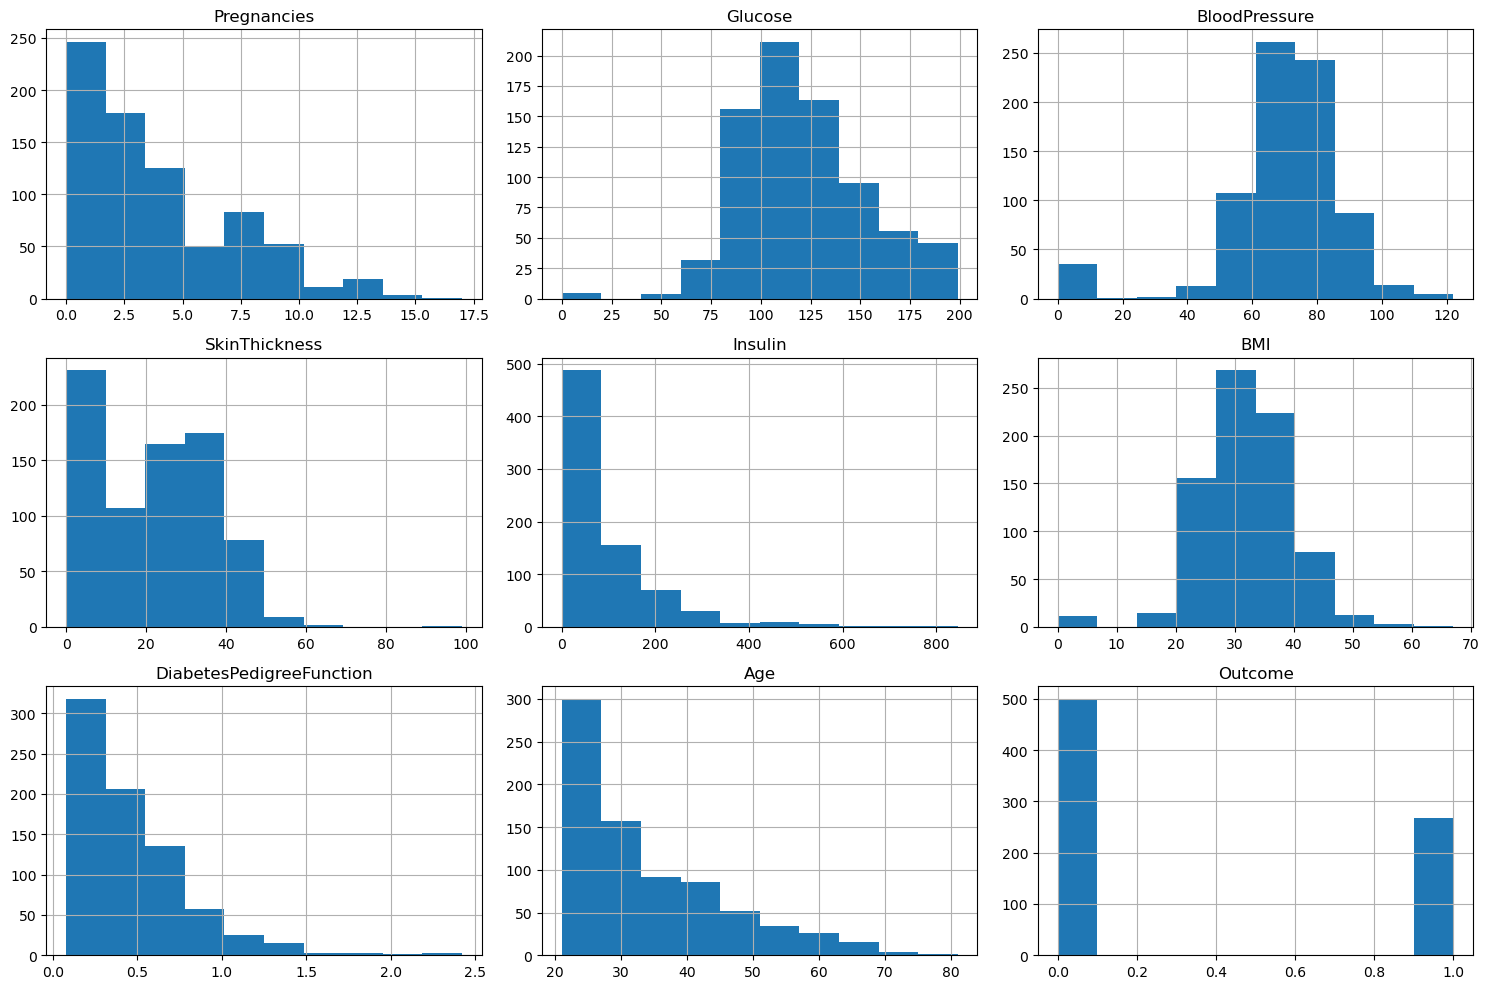

In [46]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns for the grid
n_cols = 3
n_rows = int(np.ceil(len(df.columns) / n_cols))

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Plot each column in the grid
for i, col in enumerate(df.columns):
    ax = axes[i // n_cols, i % n_cols]
    df[col].hist(ax=ax)
    ax.set_title(col)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


The histogram of each column of data indicates that some of the data columsn are long-tail skewed. It is wise to address these issues as machine learning models trained on skewed data can lead to a variety of problems affecting the accuracy of the model such as:
1. Overfitting to Majority Classes: Models may perform well on majority classes but poorly on minority classes because they receive more training examples.
2. Skewed Predictions: The model might become biased towards the majority class, leading to skewed predictions and poor performance on minority classes.
3. Sparse Data: There may not be enough examples of minority classes for the model to learn meaningful patterns.

While we are able to visually observe the skewed distribution of data, we can mathematically determine the skewedness using the Pareto index.

In [51]:
for col in df.columns:
    sorted_col = df[col].sort_values(ascending=False)
    cumulative_sum = sorted_col.cumsum()
    total_sum = sorted_col.sum()
    pareto_index = cumulative_sum.searchsorted(0.8 * total_sum) / len(sorted_col)
    print(f"{col}: Pareto index = {pareto_index}")

Pregnancies: Pareto index = 0.4388020833333333
Glucose: Pareto index = 0.71875
BloodPressure: Pareto index = 0.7122395833333334
SkinThickness: Pareto index = 0.47265625
Insulin: Pareto index = 0.2877604166666667
BMI: Pareto index = 0.72265625
DiabetesPedigreeFunction: Pareto index = 0.5677083333333334
Age: Pareto index = 0.703125
Outcome: Pareto index = 0.2786458333333333


The lower the Pareto index of a data column is, the more long-tail skewed the data is. Using the Pareto index, it is noted that the Insulin category is the most heavily skewed with a Pareto index of 0.29. To address this issue, we can take the log of the entire column to distribute the data normally. In addition, to read more about the Pareto index, https://en.wikipedia.org/wiki/Pareto_principle

<Axes: >

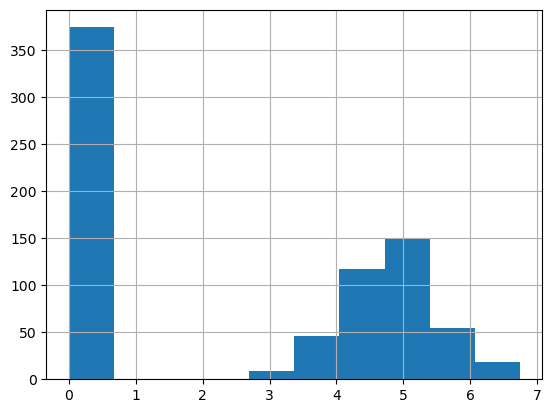

In [109]:
df['logInsulin'] = np.log(df['Insulin'] + 1)
df.drop('Insulin', axis=1, inplace=True)
df['logInsulin'].hist()

The data for this column now appears to be more normally distributed, allowing for a potential improvement in the models accuracy

In [111]:
# Observe the variability of the data among different columns
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,logInsulin
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,31.992578,0.471876,33.240885,0.348958,2.471968
std,3.369578,31.972618,19.355807,15.952218,7.884160,0.331329,11.760232,0.476951,2.460253
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,27.300000,0.243750,24.000000,0.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,0.372500,29.000000,0.000000,3.448852
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000,4.853976
max,17.000000,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000,6.741701


Observing the mean values for each data column, is is noted that the data ranges from small to large values among the different data columns. Generally, this is not recommended for training data as this introduces the effect of scale. To avoid this, normalize the data among the independent data columns. 

In [113]:
# Standardize the dependent data columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('Outcome', axis=1))
df_scaled = pd.DataFrame(scaled_features, columns=df.columns.drop('Outcome'))
df_scaled['Outcome'] = df['Outcome']

In [119]:
# Convert the data to tensors
features = df_scaled.drop('Outcome', axis=1).values
labels = df_scaled['Outcome'].values
t_features = torch.tensor(features, dtype=torch.float32)
t_labels = torch.tensor(labels, dtype=torch.float32)

In order to potentially improve model performance and accuracy, it is helpful to augment the dataset by applying various transformations to the data. This process of augmentation allows for a more diverse dataset with more training samples, and allows the model to be more tolerant to slight variations in feature patterns

In [124]:
# Data augmentation function
def augment_data(features, labels):
    noise = torch.randn(features.shape) * 0.1
    augmented_features = features + noise
    return torch.cat([features, augmented_features]), torch.cat([labels, labels])

In [126]:
# K-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize coefficients
coeffs = torch.randn(t_features.shape[1], requires_grad=True)

The code above intitalizes 5 K-folds in order to effectively the model accuracy. It helps ensure that the model generalizes well to new, unseen data by training and validating it on different subsets of the data. 5 K-folds indicate that the dataset will be split into 5 roughly equal smaller dataset, where 4 are used for training and 1 used for validation. 
- Iteration 1: Use folds 1, 2, 3, and 4 for training, and fold 5 for validation.
- Iteration 2: Use folds 1, 2, 3, and 5 for training, and fold 4 for validation.
- Iteration 3: Use folds 1, 2, 4, and 5 for training, and fold 3 for validation.
- Iteration 4: Use folds 1, 3, 4, and 5 for training, and fold 2 for validation.
- Iteration 5: Use folds 2, 3, 4, and 5 for training, and fold 1 for validation.

In this block, random coefficients are initialized which will later be optimized for accuracy using gradient descent.

The backbone of this machine learning model is to multiply the feature tensors by the label tensors and then to evaluate the accuracy of the model. Using gradient descent, the model will adjust the coefficients, tuning them to find the optimal coefficients that produce accurate results.

In [136]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the learning rate and optimizer
learning_rate = 0.1
optimizer = torch.optim.Adam([coeffs], lr=learning_rate, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define the loss function
def calc_loss(coeffs, features, labels):
    preds = (features @ coeffs).squeeze()
    loss = torch.nn.functional.binary_cross_entropy_with_logits(preds, labels)
    return loss

This code configures the training setup using PyTorch. It initializes the Adam optimizer with a learning rate of 0.1 and applies weight decay for regularization. A ReduceLROnPlateau scheduler is used to adjust the learning rate by a factor of 0.1 if the validation loss does not improve for 5 consecutive epochs. Additionally, a custom loss function is defined to compute binary cross-entropy loss with logits, which is suitable for binary classification tasks.
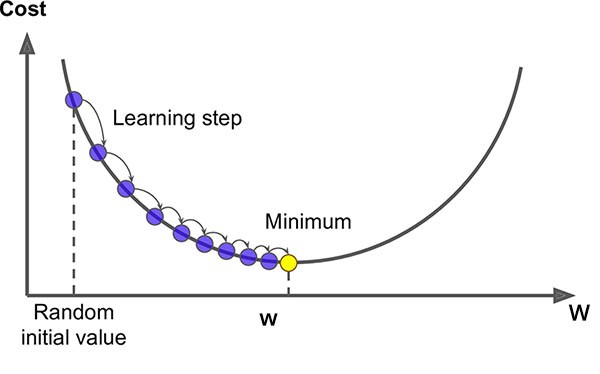

The minimum value is the point where the search for optimal coefficients will stop. Essentially, we are looking for the minima of the loss function. 


In [142]:
# Training loop with k-fold cross-validation
num_epochs = 100
batch_size = 32
best_val_accuracy = 0
patience = 10
epochs_no_improve = 0

In [151]:
for fold, (train_idx, val_idx) in enumerate(kf.split(t_features)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    train_features, train_labels = t_features[train_idx], t_labels[train_idx]
    val_features, val_labels = t_features[val_idx], t_labels[val_idx]
    
    # Data augmentation
    train_features, train_labels = augment_data(train_features, train_labels)
    
    for epoch in range(num_epochs):
        # Batch processing
        permutation = torch.randperm(train_features.size()[0])
        for i in range(0, train_features.size()[0], batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_features, batch_labels = train_features[indices], train_labels[indices]
            
            train_loss = calc_loss(coeffs, batch_features, batch_labels)
            train_loss.backward()
            optimizer.step()
        
        # Validation
        with torch.no_grad():
            val_loss = calc_loss(coeffs, val_features, val_labels)
            val_preds = torch.sigmoid(val_features @ coeffs).squeeze()
            val_accuracy = ((val_preds > 0.5).float() == val_labels).float().mean()
        
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')
        
        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
            print(f"Best coefficients for fold {fold+1}: {coeffs}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    print(f"Best validation accuracy for fold {fold+1}: {best_val_accuracy:.2f}")


Fold 1/5
Epoch 1/100, Train Loss: 0.5491, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 2/100, Train Loss: 0.5886, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 3/100, Train Loss: 0.6983, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 4/100, Train Loss: 0.5782, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 5/100, Train Loss: 0.6693, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 6/100, Train Loss: 0.3554, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 7/100, Train Loss: 0.5939, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 8/100, Train Loss: 0.5968, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 9/100, Train Loss: 0.6694, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 10/100, Train Loss: 0.6723, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 11/100, Train Loss: 0.3716, Validation Loss: 0.5611, Validation Accuracy: 0.69
Epoch 12/100, Train Loss: 0.5334, Validation Loss: 0.5611, Valida

The code performs k-fold cross-validation to evaluate the model’s performance. For each fold, it splits the dataset, trains the model with data augmentation and early stopping, and evaluates its performance. The training loop includes batching, loss calculation, backpropagation, and learning rate adjustment. The early stopping mechanism ensures that the training process halts when no significant improvement in validation accuracy is observed, thus preventing overfitting.

In [215]:
# Load the best coefficients
best_coeffs = torch.load(f'best_diabetes_coeffs_fold4.pth')

# Final evaluation
with torch.no_grad():
    final_preds = torch.sigmoid(t_features @ best_coeffs).squeeze()
    final_accuracy = ((final_preds > 0.5).float() == t_labels).float().mean()

print(f"Final model accuracy: {final_accuracy:.2f}")

Final model accuracy: 0.75


After training the model on 5 K-folds, the final model accuracy is 0.75 or 75%. While this is not a hyper accurate model, this is a very accurate prediction considering that only a single layer of weights were used. In order to observe how the model relied on matrix multiplication to make predictions, we will manually use the weights of the model to make a prediction for the first patient in the dataset

In [305]:
# Convert the data of the first patient into a tensor
first_patient = torch.tensor(df_scaled.drop('Outcome', axis=1).iloc[0].values, dtype=torch.float)
prediction = torch.sigmoid(first_patient @ coeffs).squeeze()
rounded_prediction = torch.round(prediction)
print(f"Sigmoid Value: {prediction}")
print(f"Model Prediction: {rounded_prediction}")
print(f"Actual Outcome: {df.iloc[0]['Outcome']}")

Sigmoid Value: 0.8778624534606934
Model Prediction: 1.0
Actual Outcome: 1.0


This code converts the feature data of the first patient into a tensor, uses the model's coefficients to compute a prediction probability, and then rounds this probability to either 0 or 1 to obtain the final binary classification. While making the prediction, the sigmoid function is utilized to squeeze the predicted value between 0 and 1. This is needed when performing a binary classification between 0 and 1. The sigmoid value represents the probability that the first patient has diabetes. 

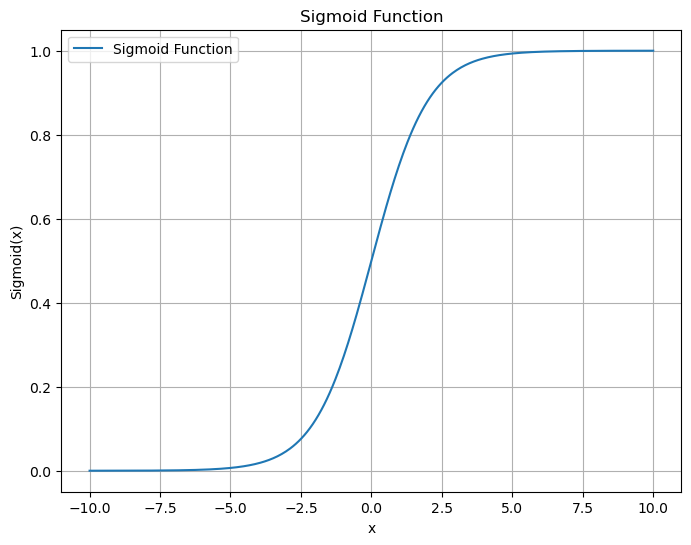

In [308]:

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate a range of x values
x = np.linspace(-10, 10, 400)

# Compute the sigmoid values for each x
y = sigmoid(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Sigmoid Function')
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.legend()
plt.show()

## Thanks for Reading! 
** Written by Arpan Roy **